The purpose of this notebook is to calculate the reaction times of the participants during the speech production trials for reporting in the Results section of the paper.

In [16]:
import mne
import os
import numpy as np
import pandas as pd
from img_pipe import img_pipe
import warnings
from tqdm.notebook import tqdm
import csv

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import rcParams as rc
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
rc['pdf.fonttype'] = 42
plt.style.use('seaborn')
import seaborn as sns
%matplotlib inline

In [ ]:
git_path = '/path/to/git/kurteff2024_code/'
data_path = '/path/to/bids/dataset/'

In [14]:
subjs = [s for s in os.listdir(
    os.path.join(git_path,"preprocessing","events","csv")) if "TCH" in s or "S0" in s]
exclude = ["TCH8"]
no_imaging = ["S0010"]
no_sh = ['S0023','TCH06'] 
subjs = [s for s in subjs if s not in exclude]

blocks = {
    s: [
        b.split("_")[-1] for b in os.listdir(os.path.join(
            git_path,"preprocessing","events","csv",s)) if f"{s}_B" in b and os.path.isfile(os.path.join(
            git_path,"preprocessing","events","csv",s,b,f"{b}_spkr_sn_all.txt"
        ))
    ] for s in subjs
}

In [17]:
# Get click epochs
tmin, tmax = -0.3, 3.5
click_epochs = {s:{'spkr':[],'mic':[],'el':[],'sh':[]} for s in subjs}
# response_times = {s:{'spkr':[],'mic':[],'el':[],'sh':[]} for s in subjs}
for s in tqdm(subjs):
    cs = ['spkr','mic','el','sh'] if s not in no_sh else ['spkr','mic']
    df = os.path.join(data_path,f"sub-{s}")
    for b in blocks[s]:
        blockid = "_".join([s,b])
        raw_fpath = os.path.join(df,blockid,"HilbAA_70to150_8band","ecog_hilbAA70to150.fif")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            raw = mne.io.read_raw_fif(raw_fpath,preload=True,verbose=False)
        fs = raw.info['sfreq']
        click_eventfile = os.path.join(git_path,"preprocessing","events","csv",s,blockid,f"{blockid}_click_eve.txt")
        if s in ['S0026','TCH14']:
            onset_idx, offset_idx, id_idx = 0,1,2
        else:
            onset_idx, offset_idx, id_idx = 0,2,4
        with open(click_eventfile,'r') as f:
            r = csv.reader(f, delimiter="\t")
            click_events = np.array([[np.ceil(float(row[onset_idx])*fs).astype(int),
                                      np.ceil(float(row[offset_idx])*fs).astype(int),
                                      int(float(row[id_idx]))] for row in r])
        for c in cs:
            if c in ['el','sh']:
                eventfile = os.path.join(git_path,"preprocessing","events","csv",s,blockid,f"{blockid}_spkr_sn_{c}.txt")
            else:
                eventfile = os.path.join(git_path,"preprocessing","events","csv",s,blockid,f"{blockid}_{c}_sn_all.txt")
            with open(eventfile,'r') as f:
                r = csv.reader(f, delimiter="\t")
                c_events = np.array([[np.ceil(float(row[0])*fs).astype(int),
                                      np.ceil(float(row[1])*fs).astype(int),
                                      int(float(row[2]))] for row in r]) 
            events = []
            for row in c_events:
                onset = row[0]
                click_idx = np.abs(click_events[:,0] - onset).argmin()
                rt = onset - click_events[click_idx,0]
                if rt > 0:
                    click_onset = click_events[click_idx,0]; click_offset = click_events[click_idx,1]
                    event_id = rt
                    events.append([click_onset,click_offset,event_id])
                else:
                    warnings.warn(
                        f"Negative response time for a {c} epoch in {blockid}, maybe look into this...")
            events = np.array(events)
            click_epochs[s][c].append(mne.Epochs(raw,events,tmin=tmin,tmax=tmax,baseline=None,
                                                 preload=True,verbose=False,event_repeated='drop'))
    for c in cs:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            click_epochs[s][c] = mne.concatenate_epochs(click_epochs[s][c],verbose=False)

  0%|          | 0/16 [00:00<?, ?it/s]

/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0006_B3, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0006_B4, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0006_B5, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0006_B2, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0006_B6, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipyker

/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a spkr epoch in S0004_B14, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0004_B14, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a sh epoch in S0004_B14, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a spkr epoch in S0004_B12, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0004_B12, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/

/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a spkr epoch in S0020_B4, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a mic epoch in S0020_B4, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a el epoch in S0020_B4, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a sh epoch in S0020_B4, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2509489732.py:46: UserWarning: Negative response time for a spkr epoch in S0018_B5, maybe look into this...
  warnings.warn(
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipyker

## Calculate reaction times for all subjects
For ISI: add 1000 msec (click-to-trial interval)

In [20]:
rts = pd.DataFrame(columns=['subj','epoch','rt'])
c = 'mic'
for s in subjs:
    for rt in click_epochs[s][c].event_id.keys():
        if len(click_epochs[s][c][rt]) > 0:
            for i in np.arange(len(click_epochs)):
                new_row = pd.DataFrame({'subj':[s],'epoch':[i+1],'rt':[int(rt)]})
                rts = rts.append(new_row,ignore_index=True)
        else:
            warnings.warn(f"No epochs for {s} {elec} event id {rt}")

/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2633995164.py:10: UserWarning: No epochs for S0015 POJ-PST'2 event id 196
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2633995164.py:10: UserWarning: No epochs for S0015 POJ-PST'2 event id 197
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2633995164.py:10: UserWarning: No epochs for S0015 POJ-PST'2 event id 223
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2633995164.py:10: UserWarning: No epochs for S0015 POJ-PST'2 event id 235
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/2633995164.py:10: UserWarning: No epochs for S0015 POJ-PST'2 event id 242
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folde

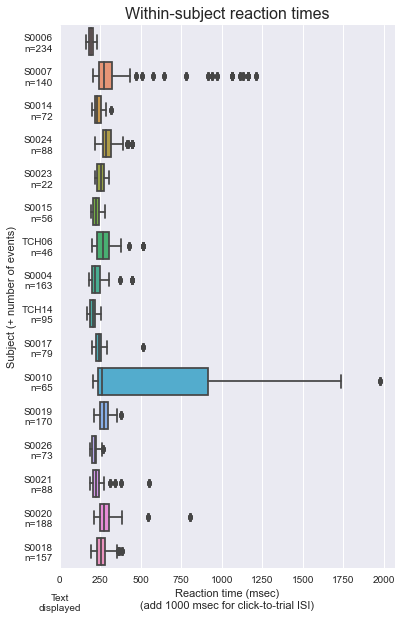

In [22]:
plt.figure(figsize=(6,10))
sns.boxplot(data=rts, y='subj',x='rt')
plt.xlabel("Reaction time (msec)\n(add 1000 msec for click-to-trial ISI)")
plt.ylabel("Subject (+ number of events)")
yticklabels = [f"%s\nn=%d" % (
    s,sum([len(click_epochs[s][c][k]) for k in click_epochs[s][c].event_id.keys()])) for s in subjs]
plt.gca().set_yticklabels(yticklabels);
plt.gca().set_xlim([0,np.array(plt.gca().get_xlim()).max()])
plt.title("Within-subject reaction times",fontsize=16);
plt.text(-0.1,len(subjs)+0.75,'Text\ndisplayed',ha='center');

In [23]:
print("Mean reaction time: %.2f ± %.2f msec"%(np.mean(rts['rt'].values),np.std(rts['rt'].values)))

Mean reaction time: 279.75 ± 161.69 msec


In [24]:
for c in ['spkr','mic','el','sh']:
    rts = pd.DataFrame(columns=['subj','epoch','rt'])
    for s in subjs:
        if s not in no_sh:
            for rt in click_epochs[s][c].event_id.keys():
                if len(click_epochs[s][c][rt]) > 0:
                    for i in np.arange(len(click_epochs)):
                        new_row = pd.DataFrame({'subj':[s],'epoch':[i+1],'rt':[int(rt)]})
                        rts = rts.append(new_row,ignore_index=True)
                else:
                    warnings.warn(f"No epochs for {s} {elec} event id {rt}")
        elif c not in ['el','sh']:
            for rt in click_epochs[s][c].event_id.keys():
                if len(click_epochs[s][c][rt]) > 0:
                    for i in np.arange(len(click_epochs)):
                        new_row = pd.DataFrame({'subj':[s],'epoch':[i+1],'rt':[int(rt)]})
                        rts = rts.append(new_row,ignore_index=True)
                else:
                    warnings.warn(f"No epochs for {s} {elec} event id {rt}")
    print("%s Mean reaction time: %.2f ± %.2f msec"%(c,np.mean(rts['rt'].values),np.std(rts['rt'].values)))

/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 231
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 244
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 245
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 246
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:19: UserWarning: No epochs for TCH06 POJ-PST'2 event id 331
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folde

spkr Mean reaction time: 299.26 ± 178.90 msec


/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 196
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 197
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 223
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 235
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 242
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folde

mic Mean reaction time: 279.75 ± 161.69 msec


/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0014 POJ-PST'2 event id 254
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 214
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 212
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 229
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 254
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folde

el Mean reaction time: 283.19 ± 141.76 msec


/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 226
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0015 POJ-PST'2 event id 230
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for TCH14 POJ-PST'2 event id 231
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for TCH14 POJ-PST'2 event id 263
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3264577312.py:11: UserWarning: No epochs for S0021 POJ-PST'2 event id 229
  warnings.warn(f"No epochs for {s} {elec} event id {rt}")
/var/folde

sh Mean reaction time: 295.06 ± 262.46 msec


## Plot response times for a single subject / electrode

In [18]:
color_palette = pd.read_csv(os.path.join(git_path,"figures","color_palette.csv"))
spkr_color = color_palette.loc[color_palette['color_id']=='perception']['hex'].values[0]
mic_color = color_palette.loc[color_palette['color_id']=='production']['hex'].values[0]
el_color = color_palette.loc[color_palette['color_id']=='consistent']['hex'].values[0]
sh_color = color_palette.loc[color_palette['color_id']=='inconsistent']['hex'].values[0]

(157, 381)


/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3810497564.py:18: UserWarning: No epochs for S0018 POJ-PST'2 event id 233
  warnings.warn(f"No epochs for {subj} {elec} event id {rt}")
/var/folders/72/y7rz3xw121n5pp8przhfnd5c0000gn/T/ipykernel_96146/3810497564.py:18: UserWarning: No epochs for S0018 POJ-PST'2 event id 256
  warnings.warn(f"No epochs for {subj} {elec} event id {rt}")


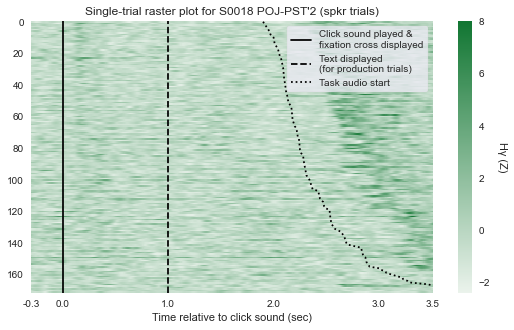

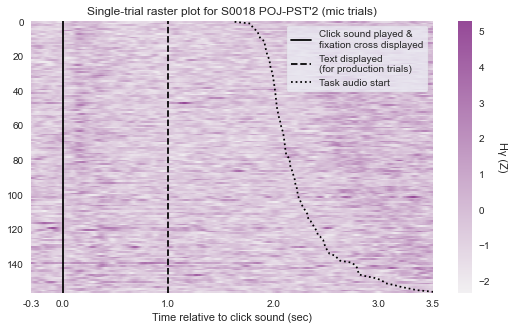

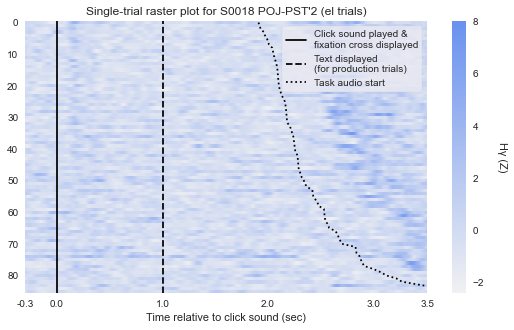

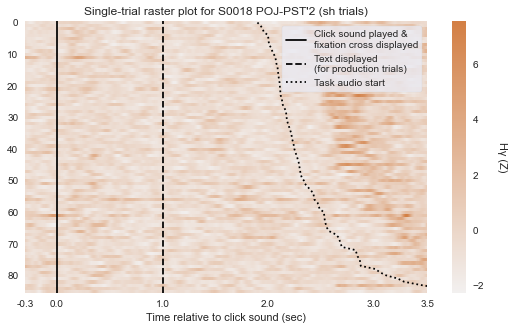

In [19]:
subj, elec = "S0018", "POJ-PST'2"
plt_colors = {'spkr':spkr_color,'mic':mic_color,'el':el_color,'sh':sh_color}
# Get the data
for c in ['spkr','mic','el','sh']:
    plt.figure(figsize=(9,5))
    x = click_epochs[subj][c].times
    resp = np.zeros(click_epochs[subj][c].get_data(picks=[elec]).squeeze().shape)
    rts = np.sort(list(click_epochs[subj][c].event_id.keys())); row = 0
    onset_line = []
    for rt in rts:
        rt_resp = click_epochs[subj][c].__getitem__(str(rt)).get_data(picks=[elec])
        n_epochs, n_chans, n_times = rt_resp.shape
        if n_epochs > 0:
            onset_line.append([row,int(rt)])
            resp[row:row+n_epochs,:] = rt_resp.squeeze(axis=1)
            row += n_epochs
        else:
            warnings.warn(f"No epochs for {subj} {elec} event id {rt}")
    # Plot
    if c == 'mic':
        print(resp.shape)
    plt.imshow(resp,aspect='auto',interpolation='nearest',cmap=sns.light_palette(plt_colors[c], as_cmap=True))
    plt.colorbar()
    plt.axvline(np.where(x==0)[0][0],color='k',label="Click sound played &\nfixation cross displayed")
    plt.axvline(np.where(x==1)[0][0],ls='--',color='k',label="Text displayed\n(for production trials)")
    plt.plot(np.array(onset_line)[:,1],np.array(onset_line)[:,0],':',color='k',label="Task audio start")
    plt.gca().set_ylabel("Hγ (Z)",rotation=270,labelpad=-490)
    plt.gca().set_xticks([0,np.where(x==0)[0][0],
                          np.where(x==1)[0][0],
                          np.where(x==2)[0][0],
                          np.where(x==3)[0][0],x.shape[0]])
    plt.gca().set_xlim([0,x.shape[0]])
    plt.gca().set_xticklabels([tmin,0.,1.,2.,3.,tmax])
    plt.xlabel("Time relative to click sound (sec)")
    plt.title(f"Single-trial raster plot for {subj} {elec} ({c} trials)")
    plt.grid(False)
    plt.legend(frameon=True,loc = 'upper right');